Data loading and cleaning

In [34]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import entropy
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.cluster import KMeans
df = pd.read_csv('./spotify_songs.csv') 
df = df.dropna()

Clustering

Entropy-Guided Decision Path Clustering algorithm.
    
This algorithm builds a hierarchical clustering tree by recursively splitting the dataset
based on the feature with the highest information gain at each step, similar to how
decision trees work, but in an unsupervised manner. This novel algorithm was programmed iteratively with 3.7 Sonnet but the intuition and design are self-engineered.

In [35]:
class FeatureInvariantClustering: 
    def __init__(self, max_depth=5, min_samples=10, min_quality=0.1, target_clusters=None, method='tree', n_estimators=5): 
        self.max_depth = max_depth # max depth of the tree
        self.min_samples = min_samples # min samples to split a node
        self.min_quality = min_quality # min quality of a split
        self.target_clusters = target_clusters # target number of clusters
        self.method = method # method to use (in practice only 'tree' and 'ensemble' are used)
        self.n_estimators = n_estimators # number of trees in ensemble
        self.tree = None 
        self.trees = []
        self.feature_distributions = {}
        self.leaf_clusters = {}
        self.cluster_paths = {}
        self.node_samples = {}
        self.refined_clusters = None # for combined method

    def fit(self, X):
        # Preprocess and optionally encode categorical features
        X_processed = self._preprocess_data(X)

        # Fit based on method
        if self.method in ['ensemble']:
            self._fit_ensemble(X_processed)
        else:
            self._fit_single_tree(X_processed)
        if self.target_clusters: # If target clusters are specified, reduce the clusters to that number
            self._reduce_clusters_to_target(X_processed)

        return self

    def predict(self, X):
        if self.method == 'ensemble' and self.refined_clusters is not None:
            return self.refined_clusters
        # If the tree exists but no refined clusters, do hard assignment
        if self.tree:
            return self._hard_assignment(X)
        raise ValueError("Model has not been fitted yet.")



    def plot_feature_importance(self, figsize=(8, 5)): # Bar chart of feature importance, computed from node quality * sample_count.
        if not self.tree and not self.trees:
            raise ValueError("No fitted trees.")
        
        # Collect feature importances
        feat_importance = defaultdict(float)
        if self.trees:  # Ensemble
            for e in self.trees:
                tree = e['tree']
                local_importance = defaultdict(float)
                self._collect_tree_qualities(tree, local_importance)
                for f, val in local_importance.items():
                    # Average over ensemble
                    feat_importance[f] += val / self.n_estimators
        else:
            self._collect_tree_qualities(self.tree, feat_importance)
        
        # Convert to a sorted list
        items = sorted(feat_importance.items(), key=lambda x: -x[1])
        features = [x[0] for x in items]
        scores = [x[1] for x in items]

        # Plot 
        plt.figure(figsize=figsize)
        y_pos = np.arange(len(features))
        plt.barh(y_pos, scores)
        plt.yticks(y_pos, features)
        plt.gca().invert_yaxis()
        plt.xlabel("Importance (Quality * N_Samples)")
        plt.title(f"Feature Importance ({self.method} method)")
        plt.tight_layout()
        plt.show()


    def visualize_clusters(self, X, figsize=(8, 6)): # Projects data to 2D space and visualizes clusters
        if isinstance(X, pd.DataFrame):
            X_num = X.select_dtypes(include=[np.number])
        else:
            X_num = pd.DataFrame(X)

        clusters = self.predict(X)
        if X_num.shape[1] > 2:
            pca = PCA(n_components=2, random_state=42)
            emb = pca.fit_transform(X_num)
            label_x, label_y = 'PC1', 'PC2'
        else:
            emb = X_num.values
            label_x, label_y = X_num.columns[0], (X_num.columns[1] if X_num.shape[1] == 2 else "Feature2")

        plt.figure(figsize=figsize)
        plt.scatter(emb[:, 0], emb[:, 1], c=clusters, s=40, alpha=0.8, edgecolors='k')
        plt.xlabel(label_x)
        plt.ylabel(label_y)
        plt.title(f"Cluster Visualization ({self.method} method)")
        plt.tight_layout()
        plt.show()

    def _preprocess_data(self, X):
        """
        Basic preprocessing: copy, handle categorical columns if needed.
        """
        Xc = X.copy()
        # For categorical columns, store a simple encoder in self.feature_distributions if not present
        for col in Xc.select_dtypes(include=['object', 'category']).columns:
            if col not in self.feature_distributions:
                uniq = Xc[col].dropna().unique()
                encoder_map = {val: i for i, val in enumerate(uniq)}
                self.feature_distributions[col] = {
                    'type': 'categorical',
                    'encoder': type('CatEncoder', (), {
                        'transform': lambda arr, em=encoder_map: [em.get(a, -1) for a in arr],
                        'classes_': list(uniq)
                    })
                }
        return Xc

    def _fit_single_tree(self, X):
        self.tree = self._build_tree(X, depth=0, node_id=1)
        # Assign cluster IDs to leaves
        self._assign_leaf_clusters(self.tree, cluster_id=0)
        # Extract final paths
        self._extract_cluster_paths(self.tree)

    def _fit_ensemble(self, X):
        self.trees = []
        n_features = len(X.columns)
        base_id = 0

        for _ in range(self.n_estimators):
            # Shuffle feature order
            feats = list(X.columns)
            np.random.shuffle(feats)

            tree = self._build_tree(X, depth=0, node_id=1, preferred_features=feats)
            # Assign clusters
            self._assign_leaf_clusters(tree, cluster_id=base_id)
            # Extract paths
            local_paths = {}
            self._extract_cluster_paths(tree, path_map=local_paths)

            # Keep leaf clusters for this tree
            leaf_map = {}
            for k, v in self.leaf_clusters.items():
                if v >= base_id and v < base_id + 1000:
                    leaf_map[k] = v

            self.trees.append({
                'tree': tree,
                'paths': local_paths,
                'leaf_clusters': leaf_map
            })
            base_id += 1000

        # Combine cluster labels across trees
        self._combine_ensemble_predictions(X)

    def _build_tree(self, X, depth, node_id, parent_feature=None, preferred_features=None): # Recursively builds the tree
        """
        Recursively build a tree: each node is either split or leaf.
        """
        if depth >= self.max_depth or len(X) <= self.min_samples:
            return {'type': 'leaf', 'node_id': node_id, 'n_samples': len(X), 'children': {}}

        # Find best feature
        best_feat, best_dist, best_quality = self._find_best_split(X, parent_feature, preferred_features)

        # If no decent feature found, stop
        if not best_feat or best_quality < self.min_quality:
            return {'type': 'leaf', 'node_id': node_id, 'n_samples': len(X), 'children': {}}

        node = {
            'type': 'split',
            'node_id': node_id,
            'feature': best_feat,
            'distribution': best_dist,
            'quality': best_quality,
            'n_samples': len(X),
            'children': {}
        }
        self.node_samples[node_id] = len(X)

        # Split based on distribution
        feat_vals = X[best_feat]
        if isinstance(best_dist, GaussianMixture):
            # Gaussian Mixture Model
            vals = feat_vals.fillna(feat_vals.mean()).values.reshape(-1, 1)
            comps = best_dist.predict(vals)
            for c_id in range(best_dist.n_components):
                subset = X[comps == c_id]
                if len(subset) == 0:
                    continue
                child_id = node_id * 10 + c_id + 1
                node['children'][c_id] = self._build_tree(
                    subset, depth + 1, child_id, parent_feature=best_feat, preferred_features=preferred_features
                )
        elif isinstance(best_dist, dict) and best_dist['type'] == 'threshold': # for threshold model
            thr = best_dist['threshold']
            left = X[feat_vals <= thr]
            right = X[feat_vals > thr]
            c_id_left = node_id * 10 + 1
            c_id_right = node_id * 10 + 2
            if len(left) > 0:
                node['children'][0] = self._build_tree(left, depth+1, c_id_left, best_feat, preferred_features)
            if len(right) > 0:
                node['children'][1] = self._build_tree(right, depth+1, c_id_right, best_feat, preferred_features)

        elif isinstance(best_dist, dict) and best_dist['type'] == 'categorical': # for categorical model
            enc = best_dist['encoder']
            cats = enc.classes_
            for i, cat in enumerate(cats):
                subset = X[feat_vals == cat]
                if len(subset) == 0:
                    continue
                child_id = node_id * 10 + i + 1
                node['children'][i] = self._build_tree(
                    subset, depth+1, child_id, parent_feature=best_feat, preferred_features=preferred_features
                )
        else:
            # Fallback: treat as leaf
            node['type'] = 'leaf'
            node['children'] = {}

        return node

    def _find_best_split(self, X, parent_feature=None, preferred_features=None): # Finds the best feature to split on, based on quality metrics.
        best_feat = None
        best_dist = None
        best_quality = -1
        features = preferred_features if preferred_features else X.columns

        for feat in features: # Iterate over features
            if feat == parent_feature: #
                continue
            fvals = X[feat]
            if fvals.isna().sum() > len(X)*0.5 or len(fvals.unique()) <= 1: # Too many missing values or not enough unique values
                continue

            # If we already have a distribution for this feat, check quality 
            dist_model = self.feature_distributions.get(feat, None)
            if dist_model is not None:
                q = self._calculate_distribution_quality(fvals, dist_model) # Calculate quality of the distribution
                if q > best_quality: # If better than current best, update
                    best_feat = feat
                    best_dist = dist_model
                    best_quality = q
            else:
                # Attempt to fit a GMM or threshold/categorical
                if fvals.dtype.kind in 'ifc':
                    # Fit GMM for 2-3 components (arbitrary choice)
                    arr = fvals.fillna(fvals.mean()).values.reshape(-1, 1)
                    best_gmm, best_bic = None, float('inf')
                    for c in [2, 3]:
                        if len(arr) < c: 
                            continue
                        gmm = GaussianMixture(n_components=c, covariance_type='full', random_state=42)
                        gmm.fit(arr)
                        bic = gmm.bic(arr)
                        if bic < best_bic:
                            best_bic = bic
                            best_gmm = gmm
                    # Evaluate GMM
                    if best_gmm:
                        q = self._calculate_distribution_quality(arr, best_gmm)
                        if q > best_quality:
                            best_feat, best_dist, best_quality = feat, best_gmm, q
                            self.feature_distributions[feat] = best_gmm

                    # Also try threshold model
                    thr = np.median(arr)
                    thr_model = {'type': 'threshold', 'threshold': thr}
                    thr_q = self._calculate_threshold_quality(arr, thr)
                    if thr_q > best_quality:
                        best_feat, best_dist, best_quality = feat, thr_model, thr_q
                        self.feature_distributions[feat] = thr_model

                else:
                    # Categorical
                    cats = fvals.dropna().unique()
                    if len(cats) > 1:
                        enc_map = {c:i for i,c in enumerate(cats)}
                        cat_model = {
                            'type': 'categorical',
                            'encoder': type('CatEncoder', (), {
                                'transform': lambda arr, em=enc_map: [em.get(a, -1) for a in arr],
                                'classes_': list(cats)
                            })
                        }
                        cat_q = self._calculate_categorical_quality(fvals)
                        if cat_q > best_quality:
                            best_feat, best_dist, best_quality = feat, cat_model, cat_q
                            self.feature_distributions[feat] = cat_model

        return best_feat, best_dist, best_quality

    def _assign_leaf_clusters(self, node, cluster_id=0, base_id=0): # Assigns cluster IDs to leaf nodes and stores them
        if node['type'] == 'leaf':
            c = cluster_id + base_id
            self.leaf_clusters[node['node_id']] = c
            node['cluster'] = c
            return cluster_id + 1
        nxt = cluster_id
        for ch in node['children'].values():
            nxt = self._assign_leaf_clusters(ch, nxt, base_id)
        return nxt

    def _reduce_clusters_to_target(self, X): # Merges clusters to reduce to target_clusters using AgglomerativeClustering

        # If target_clusters is None or there's only 1 cluster, do nothing
        if not self.target_clusters or self.target_clusters < 2:
            return

        # If we don't yet have refined_clusters, create them from a hard assignment
        if self.refined_clusters is None:
            self.refined_clusters = self._hard_assignment(X)

        old_labels = self.refined_clusters
        unique_labels = np.unique(old_labels)
        n_current = len(unique_labels)
        if n_current <= self.target_clusters:
            # Already fewer (or equal) than desired. No merge needed
            return

        # Convert X to array if it's a DataFrame
        if hasattr(X, 'values'):
            X_arr = X.values
        else:
            X_arr = np.array(X)

        # 1) Compute centroids of each old cluster
        label_to_index = {}
        centroids = []
        idx_count = 0
        for c in unique_labels:
            idx = (old_labels == c)
            if np.sum(idx) == 0:
                continue
            cen = X_arr[idx].mean(axis=0)
            centroids.append(cen)
            label_to_index[c] = idx_count
            idx_count += 1

        centroids = np.vstack(centroids)  # change shape to (#clusters, n_features)

        # 2) Merge clusters with AgglomerativeClustering
        agg = AgglomerativeClustering(n_clusters=self.target_clusters, linkage='ward')
        new_centroid_labels = agg.fit_predict(centroids)

        # 3) Reassign each sample's old cluster to new cluster
        new_labels = np.zeros_like(old_labels)
        for old_c in label_to_index:
            old_idx = label_to_index[old_c]
            merged_label = new_centroid_labels[old_idx]
            new_labels[old_labels == old_c] = merged_label

        # 4) Store them as final clusters
        self.refined_clusters = new_labels


    def _extract_cluster_paths(self, node, curr_path=None, path_map=None): # Recursively store the path for each leaf in self.cluster_paths or in path_map
        if curr_path is None:
            curr_path = []
        if path_map is None:
            path_map = self.cluster_paths  # default to the class level dictionary

        if node['type'] == 'leaf': # if leaf node, store the path
            path_map[node['node_id']] = curr_path
            return
        
        feat = node['feature']
        dist = node['distribution']
        for child_key, child_node in node['children'].items(): # Recursively call for each child node
            if isinstance(dist, GaussianMixture):
                # Use component mean or label
                if hasattr(dist, 'means_') and child_key < len(dist.means_):
                    val = f"~{dist.means_[child_key][0]:.2f}"
                else:
                    val = f"GMM_{child_key}"
            elif isinstance(dist, dict) and dist['type'] == 'threshold':
                t = dist['threshold']
                val = f"<= {t:.2f}" if child_key == 0 else f"> {t:.2f}"
            elif isinstance(dist, dict) and dist['type'] == 'categorical':
                cats = dist['encoder'].classes_
                val = str(cats[child_key]) if child_key < len(cats) else f"Cat_{child_key}"
            else:
                val = f"split_{child_key}"
            self._extract_cluster_paths(child_node, curr_path + [(feat, val)], path_map)

    def _calculate_distribution_quality(self, values, distribution): # Calculates the quality of a distribution based on its type
        if isinstance(distribution, GaussianMixture):
            arr = np.array(values).reshape(-1,1)
            bic_val = distribution.bic(arr)
            return max(0.0, 1.0 - abs(bic_val)/(10*len(arr)))

        elif isinstance(distribution, dict):
            if distribution['type'] == 'threshold':
                return self._calculate_threshold_quality(values, distribution['threshold'])
            elif distribution['type'] == 'categorical':
                return self._calculate_categorical_quality(values)
        return 0.0

    def _calculate_threshold_quality(self, vals, thr): # Calculates the quality of a threshold split based on balance of values
        vals = vals.flatten() if hasattr(vals, 'flatten') else vals
        below = np.sum(vals <= thr)
        above = len(vals) - below
        total = len(vals)
        if total == 0: # no samples
            return 0.0
        balance = min(below/total, above/total)*2
        return balance

    def _calculate_categorical_quality(self, vals): # Calculates the quality of a categorical split based on entropy of values
        vc = vals.value_counts(normalize=True)
        ent = -np.sum(vc * np.log2(vc + 1e-9))
        max_ent = np.log2(len(vc)) if len(vc) > 1 else 1.0
        return max(0.0, 1.0 - ent/max_ent)

    def _combine_ensemble_predictions(self, X): # Combines predictions from all trees in the ensemble
        # For each tree, do a hard assignment
        all_preds = []
        for tinfo in self.trees:
            self.tree = tinfo['tree']
            self.leaf_clusters = tinfo['leaf_clusters']
            all_preds.append(self._hard_assignment(X))

        # Restore to the first tree for any subsequent calls
        self.tree = self.trees[0]['tree']
        self.leaf_clusters = self.trees[0]['leaf_clusters']

        # Combine predictions
        all_preds = np.array(all_preds)
        combined = []
        mapping = {}
        cid = 0

        for col in all_preds.T: # for each sample, find the cluster ID
            tp = tuple(col)
            if tp not in mapping:
                mapping[tp] = cid
                cid += 1
            combined.append(mapping[tp])

        self.refined_clusters = np.array(combined)

    def _calculate_leaf_probabilities(self, sample, node, parent_prob=1.0): # Recursively computes the probability of a sample belonging to each leaf node
        leaf_probs = {}
        # If leaf
        if node['type'] == 'leaf':
            leaf_probs[node['node_id']] = parent_prob
            return leaf_probs

        # Determine which children and with what probability we follow
        feat = node['feature']
        dist = node['distribution']
        val = sample.get(feat, np.nan)

        # If no distribution or missing val, distribute evenly
        if dist is None or pd.isnull(val):
            n_child = len(node['children'])
            if n_child == 0:
                leaf_probs[node['node_id']] = parent_prob
            else:
                frac = parent_prob / n_child
                for c in node['children'].values():
                    sub_probs = self._calculate_leaf_probabilities(sample, c, frac)
                    for lid, p in sub_probs.items():
                        leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # If GMM
        if isinstance(dist, GaussianMixture):
            arr = np.array([[val]]) if not pd.isnull(val) else np.array([[0]])
            comp_probs = dist.predict_proba(arr)[0] if dist.means_.shape[0] > 1 else [1.0]
            for c_id, child in node['children'].items(): # for each child, get the probability of that component
                if c_id < len(comp_probs):
                    frac = parent_prob * comp_probs[c_id]
                    if frac > 1e-6:
                        sub_probs = self._calculate_leaf_probabilities(sample, child, frac)
                        for lid, p in sub_probs.items():
                            leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs # return the probabilities for each leaf

        # If threshold
        if dist['type'] == 'threshold':
            thr = dist['threshold']
            below_prob = 0.5
            above_prob = 0.5
            # if val <= threshold => mostly go left (arbitrary choice)
            if val <= thr:
                below_prob = 0.9
                above_prob = 0.1
            else:
                below_prob = 0.1
                above_prob = 0.9

            child_left = node['children'].get(0, None)
            child_right = node['children'].get(1, None)
            if child_left:
                sub_probs = self._calculate_leaf_probabilities(sample, child_left, parent_prob*below_prob)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            if child_right:
                sub_probs = self._calculate_leaf_probabilities(sample, child_right, parent_prob*above_prob)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # If categorical
        if dist['type'] == 'categorical':
            enc = dist['encoder']
            cats = enc.classes_
            try:
                idx = enc.transform([val])[0]
            except:
                # evenly distribute if unknown
                idx = -1
            n_cat = len(cats)
            cat_probs = np.ones(n_cat)*(1/n_cat)  # default uniform
            if 0 <= idx < n_cat:
                # give 90% to the matched cat, 10% to the rest
                cat_probs[:] = 0.1/(n_cat-1) if n_cat>1 else 1.0
                cat_probs[idx] = 0.9

            for c_id, child in node['children'].items():
                if c_id < len(cat_probs):
                    frac = parent_prob*cat_probs[c_id]
                    if frac>1e-6:
                        sub_probs = self._calculate_leaf_probabilities(sample, child, frac)
                        for lid, p in sub_probs.items():
                            leaf_probs[lid] = leaf_probs.get(lid, 0) + p
            return leaf_probs

        # Fallback to even distribution
        # If no distribution or missing val, distribute evenly
        n_child = len(node['children'])
        if n_child == 0:
            leaf_probs[node['node_id']] = parent_prob
        else:
            frac = parent_prob / n_child
            for c in node['children'].values():
                sub_probs = self._calculate_leaf_probabilities(sample, c, frac)
                for lid, p in sub_probs.items():
                    leaf_probs[lid] = leaf_probs.get(lid, 0) + p
        return leaf_probs


    def _hard_assignment(self, X): # Descend the tree for each sample in X and pick the leaf's cluster
        Xc = self._preprocess_data(X)
        labels = []
        for _, row in Xc.iterrows():
            labels.append(self._predict_sample(row, self.tree))
        return np.array(labels)

    def _predict_sample(self, sample, node): # Predict the cluster for a single sample by traversing the tree

        if node['type'] == 'leaf':
            return node.get('cluster', 0)
        feat = node['feature']
        dist = node['distribution']
        val = sample.get(feat, np.nan)

        # If distribution is missing or val is NaN then pick first child
        if dist is None or pd.isnull(val):
            if node['children']:
                return self._predict_sample(sample, next(iter(node['children'].values())))
            return node.get('cluster', 0)

        # GMM
        if isinstance(dist, GaussianMixture):
            arr = np.array([[val]]) if not pd.isnull(val) else np.array([[0]])
            comp = dist.predict(arr)[0]
            child = node['children'].get(comp, None)
            if child is not None:
                return self._predict_sample(sample, child)
            # fallback
            return node.get('cluster',0)

        # Threshold
        if dist['type'] == 'threshold':
            thr = dist['threshold']
            side = 1 if val>thr else 0
            child = node['children'].get(side, None)
            if child is not None:
                return self._predict_sample(sample, child)
            return node.get('cluster',0)

        # Categorical
        if dist['type'] == 'categorical':
            try:
                idx = dist['encoder'].transform([val])[0]
            except:
                idx = -1
            child = node['children'].get(idx, None)
            if child is not None:
                return self._predict_sample(sample, child)
            return node.get('cluster',0)

        # Fallback
        if node['children']:
            return self._predict_sample(sample, next(iter(node['children'].values())))
        return node.get('cluster',0)

    def _build_leaf_distance_matrix(self): # Builds a distance matrix for the leaf nodes based on path overlap
        leaf_ids = sorted(self.leaf_clusters.keys()) # get the leaf node IDs
        n = len(leaf_ids)
        if n < 2: # not enough leaf nodes to compute distance
            return None, leaf_ids
        dist = np.zeros((n,n))
        for i in range(n): # iterate over leaf nodes
            path1 = self.cluster_paths.get(leaf_ids[i], []) # get the path for the leaf node
            for j in range(i+1, n): # iterate over the rest of the leaf nodes
                path2 = self.cluster_paths.get(leaf_ids[j], []) #
                cl = 0
                for (fa, va), (fb, vb) in zip(path1, path2): # iterate over the features in the path
                    if fa == fb and va == vb:
                        cl += 1 # count the number of common features
                    else:
                        break
                denom = max(len(path1), len(path2)) or 1
                d = 1 - (cl/denom)
                dist[i,j] = d
                dist[j,i] = d
        return dist, leaf_ids # distance matrix for the leaf nodes

    def _extract_common_features(self, paths): # Extracts common features from the paths
        feature_counts = defaultdict(int)
        feature_values = defaultdict(set)
        total = len(paths)

        for path in paths:
            used_feats = set()
            for (f, v) in path:
                if f not in used_feats:
                    feature_counts[f] += 1
                    used_feats.add(f)
                feature_values[f].add(v)

        common = {}
        for f, ct in feature_counts.items():
            if ct >= total/2:
                common[f] = feature_values[f]
        return common

    def _collect_tree_qualities(self, node, store): # Collects the quality of each feature in the tree
        if node['type'] == 'split':
            f = node['feature']
            store[f] += node['quality'] * node['n_samples']
            for ch in node['children'].values():
                self._collect_tree_qualities(ch, store)

    @staticmethod
    def _is_numerical_str(x): # Checks if a value is numerical or can be converted to a number
        if isinstance(x, (int, float, np.number)):
            return True
        if isinstance(x, str):
            try:
                float(x)
                return True
            except:
                return False
        return False

In [36]:
def plot_clusters_2d(X_numeric, labels, title="Cluster Visualization"): # Plots a 2D scatter plot of the clusters
    if X_numeric.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        emb = pca.fit_transform(X_numeric)
        xlab, ylab = "PC1", "PC2"
    else:
        emb = X_numeric.values
        cols = list(X_numeric.columns)
        xlab = cols[0] if len(cols)>0 else "Feature1"
        ylab = cols[1] if len(cols)>1 else "Feature2"

    plt.scatter(emb[:, 0], emb[:, 1], c=labels, s=40, alpha=0.8, edgecolors='k')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [37]:
df = pd.read_csv('./spotify_songs.csv') 
df = df.dropna()

In [38]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(df))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

df_train_full = df.iloc[train_indices].copy()
df_test_full = df.iloc[test_indices].copy()

X_train = df_train_full[[
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo'
]].values
X_test = df_test_full[[
    'danceability','energy','loudness','speechiness',
    'acousticness','instrumentalness','valence','tempo'
]].values
y_train = df_train_full['playlist_genre'].values  


In [39]:
def evaluate_internal_metrics(X_data, labels): # Evaluates clustering quality using silhouette, calinski, and davies metrics
    """
    Returns silhouette, calinski, davies as a dict.
    If only 1 unique cluster, sets them to 0.
    """
    n_clust = len(set(labels))
    if n_clust <= 1:
        return {'sil': 0.0, 'calinski': 0.0, 'davies': 0.0}
    sil = silhouette_score(X_data, labels)
    cal = calinski_harabasz_score(X_data, labels)
    dav = davies_bouldin_score(X_data, labels)
    return {'sil': sil, 'calinski': cal, 'davies': dav}

In [40]:
def cluster_majority_vote_accuracy(labels, true_labels):
    """
    Assigns each cluster the majority (most common) class from 'true_labels'
    and computes the overall accuracy.
    """
    from collections import Counter
    # Map: cluster_id -> list of y-values
    cluster_to_targets = {}
    for c, t in zip(labels, true_labels):
        cluster_to_targets.setdefault(c, []).append(t)
    
    # For each cluster, find the majority label
    cluster_major_label = {}
    for c, targets in cluster_to_targets.items():
        common = Counter(targets).most_common(1)[0][0]  # label with max count
        cluster_major_label[c] = common
    
    # Now measure accuracy
    correct = 0
    total = len(labels)
    for c, actual_label in zip(labels, true_labels):
        pred_label = cluster_major_label[c]
        if pred_label == actual_label:
            correct += 1
    return correct / total if total>0 else 0


--- Best Ensemble by Silhouette ---
{'max_depth': 11, 'min_quality': 0.2, 'target_clusters': 2} {'sil': 0.5174646744772209, 'calinski': 40625.09904635372, 'davies': 0.6636611991730604} 0.25683497068007005

--- Best Ensemble by Accuracy ---
{'max_depth': 7, 'min_quality': 0.5, 'target_clusters': 100} {'sil': -0.34885394234295297, 'calinski': 498.23592670541126, 'davies': 26.880913335228424} 0.38066407737415275

--- KMeans Best by Silhouette ---
n_clusters=2, silhouette=0.538, cal=41019.25, dav=0.63, acc=0.257

--- KMeans Best by Accuracy ---
n_clusters=50, silhouette=0.338, cal=78451.59, dav=0.85, acc=0.351

===== Final Comparison of 'Best' Models =====
Ensemble_sil: config={'max_depth': 11, 'min_quality': 0.2, 'target_clusters': 2}, #clusters=2, sil=0.517, cal=40625.10, dav=0.66, acc=0.257
Ensemble_acc: config={'max_depth': 7, 'min_quality': 0.5, 'target_clusters': 100}, #clusters=100, sil=-0.349, cal=498.24, dav=26.88, acc=0.381
KMeans_sil: config={'n_clusters': 2}, #clusters=2, sil=

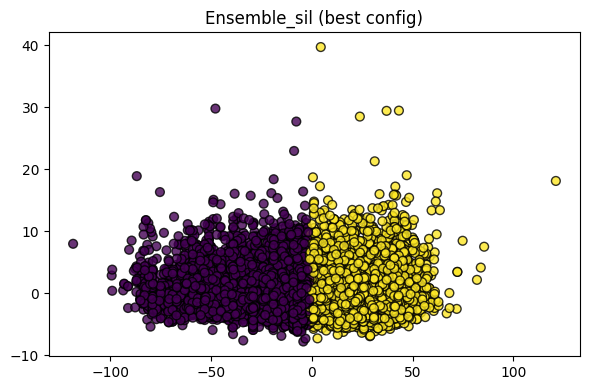

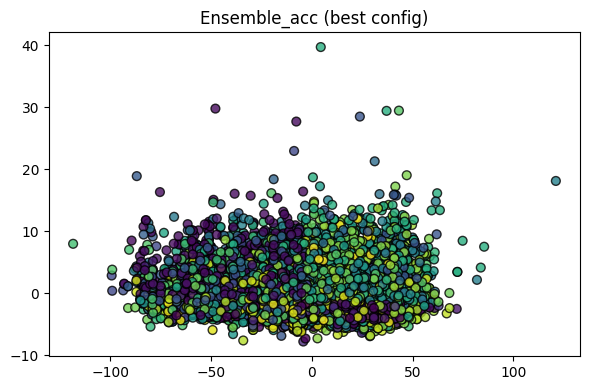

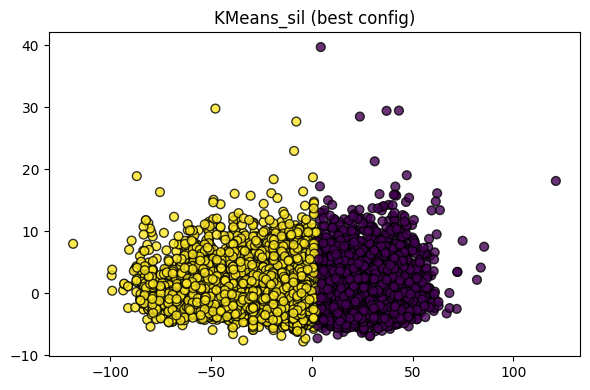

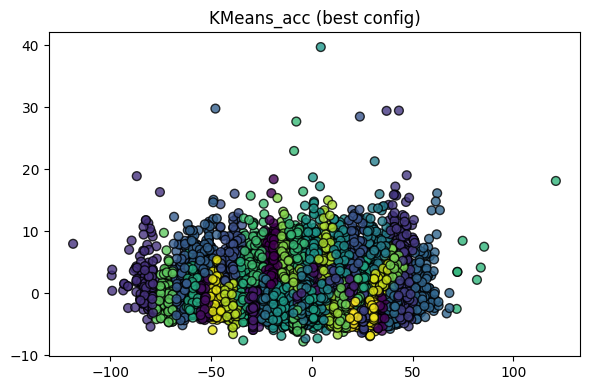


Single sample assigned to cluster [ 1 77  6 ... 88 21 88] by ensemble method.

=== Explaining path in the first ensemble tree ===
Node 1: splitting on feature 'acousticness', sample value=0.00266
  distribution={'type': 'threshold', 'threshold': 0.08105000000000001}
  => goes to child 0
  Node 11: splitting on feature 'speechiness', sample value=0.0354
    distribution={'type': 'threshold', 'threshold': 0.0607}
    => goes to child 0
    Node 111: splitting on feature 'tempo', sample value=127.932
      distribution={'type': 'threshold', 'threshold': 124.03450000000001}
      => goes to child 1
      Node 1112: splitting on feature 'loudness', sample value=-4.96
        distribution={'type': 'threshold', 'threshold': -5.607}
        => goes to child 1
        Node 11122: splitting on feature 'danceability', sample value=0.723
          distribution={'type': 'threshold', 'threshold': 0.628}
          => goes to child 1
          Node 111222: splitting on feature 'valence', sample value

In [41]:
# hyperparameters for FeatureInvariantClustering
feature_invariant_param_grid = [
    {
        'max_depth': d,
        'min_quality': q,
        'target_clusters': k
    }
    for d in [7,11]        
    for q in [0.2,0.5]
    for k in [2,50,100]
]

ec_method = 'ensemble'
n_estimators = 1000

# KMeans param candidates
kmeans_clusters_grid = [2,10,50]

best_ens_sil_score = -999
best_ens_sil_model = None
best_ens_sil_cfg = None
best_ens_sil_labels = None
best_ens_sil_acc = None
best_ens_sil_metrics = None

best_ens_acc_score = -999
best_ens_acc_model = None
best_ens_acc_cfg = None
best_ens_acc_labels = None
best_ens_acc_metrics = None

for cfg in feature_invariant_param_grid:
    model = FeatureInvariantClustering(
        method=ec_method,
        max_depth=cfg['max_depth'],
        min_quality=cfg['min_quality'],
        target_clusters=cfg['target_clusters'],
        n_estimators=n_estimators
    )
    model.fit(df_train_full[[
        'danceability','energy','loudness','speechiness',
        'acousticness','instrumentalness','valence','tempo'
    ]])  # pass only numeric columns
    labels = model.predict(df_train_full[[
        'danceability','energy','loudness','speechiness',
        'acousticness','instrumentalness','valence','tempo'
    ]])

    mets = evaluate_internal_metrics(X_train, labels)
    sil = mets['sil']
    acc = cluster_majority_vote_accuracy(labels, y_train)

    # Check if best by silhouette
    if sil > best_ens_sil_score:
        best_ens_sil_score = sil
        best_ens_sil_model = model
        best_ens_sil_cfg = cfg
        best_ens_sil_labels = labels
        best_ens_sil_acc = acc
        best_ens_sil_metrics = mets

    # Check if best by accuracy
    if acc > best_ens_acc_score:
        best_ens_acc_score = acc
        best_ens_acc_model = model
        best_ens_acc_cfg = cfg
        best_ens_acc_labels = labels
        best_ens_acc_metrics = mets

print("\n--- Best Ensemble by Silhouette ---")
print(best_ens_sil_cfg, best_ens_sil_metrics, best_ens_sil_acc)
print("\n--- Best Ensemble by Accuracy ---")
print(best_ens_acc_cfg, best_ens_acc_metrics, best_ens_acc_score)


best_km_acc_score = -999
best_km_acc_model = None
best_km_acc_nclust = None
best_km_acc_labels = None
best_km_acc_metrics = None

best_km_sil_score = -999
best_km_sil_model = None
best_km_sil_nclust = None
best_km_sil_labels = None
best_km_sil_metrics = None


for k in kmeans_clusters_grid:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train)
    labels = km.labels_

    mets = evaluate_internal_metrics(X_train, labels)
    sil = mets['sil']
    acc = cluster_majority_vote_accuracy(labels, y_train)

    # Best by silhouette
    if sil > best_km_sil_score:
        best_km_sil_score = sil
        best_km_sil_model = km
        best_km_sil_nclust = k
        best_km_sil_labels = labels
        best_km_sil_metrics = mets
        best_km_sil_acc = acc

    # Best by accuracy
    if acc > best_km_acc_score:
        best_km_acc_score = acc
        best_km_acc_model = km
        best_km_acc_nclust = k
        best_km_acc_labels = labels
        best_km_acc_metrics = mets

print("\n--- KMeans Best by Silhouette ---")
print(f"n_clusters={best_km_sil_nclust}, silhouette={best_km_sil_score:.3f}, cal={best_km_sil_metrics['calinski']:.2f}, dav={best_km_sil_metrics['davies']:.2f}, acc={best_km_sil_acc:.3f}")

print("\n--- KMeans Best by Accuracy ---")
print(f"n_clusters={best_km_acc_nclust}, silhouette={best_km_acc_metrics['sil']:.3f}, cal={best_km_acc_metrics['calinski']:.2f}, dav={best_km_acc_metrics['davies']:.2f}, acc={best_km_acc_score:.3f}")

results = {
    'Ensemble_sil': {
        'cfg': best_ens_sil_cfg,
        'labels': best_ens_sil_labels,
        'metrics': best_ens_sil_metrics,
        'accuracy': best_ens_sil_acc
    },
    'Ensemble_acc': {
        'cfg': best_ens_acc_cfg,
        'labels': best_ens_acc_labels,
        'metrics': best_ens_acc_metrics,
        'accuracy': best_ens_acc_score
    },
    'KMeans_sil': {
        'cfg': {'n_clusters': best_km_sil_nclust},
        'labels': best_km_sil_labels,
        'metrics': best_km_sil_metrics,
        'accuracy': best_km_sil_acc
    },
    'KMeans_acc': {
        'cfg': {'n_clusters': best_km_acc_nclust},
        'labels': best_km_acc_labels,
        'metrics': best_km_acc_metrics,
        'accuracy': best_km_acc_score
    }
}

print("\n===== Final Comparison of 'Best' Models =====")
for name, info in results.items():
    m = info['metrics']
    print(f"{name}: config={info['cfg']}, #clusters={len(set(info['labels']))}, "
          f"sil={m['sil']:.3f}, cal={m['calinski']:.2f}, dav={m['davies']:.2f}, acc={info['accuracy']:.3f}")

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(X_train)

def plot_clusters(X_2d, labs, title):
    plt.figure(figsize=(6,4))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labs, s=40, alpha=0.8, edgecolor='k')
    plt.title(title)
    plt.tight_layout()
    plt.show()

for method, info in results.items():
    labs = info['labels']
    plot_clusters(Xp, labs, title=f"{method} (best config)")


def explain_ensemble_path(model, sample_df): # This function explains the path a sample takes in the first tree of the ensemble
    if not model.trees:
        print("No trees found in the ensemble.")
        return

    tree_info = model.trees[0]
    root_node = tree_info['tree']

    print("\n=== Explaining path in the first ensemble tree ===")
    _print_tree_path(root_node, sample_df.iloc[0], model.feature_distributions)


def _print_tree_path(node, sample_series, feature_distributions, depth=0): # Recursively descend from the current node to a leaf, printing out the split condition and chosen child at each step.
    indent = "  " * depth
    node_id = node['node_id']

    # If it's a leaf
    if node['type'] == 'leaf':
        cluster_label = node.get('cluster', None)
        print(f"{indent}Reached leaf node {node_id}, cluster={cluster_label}")
        return

    # Otherwise
    feat = node['feature']
    dist = node['distribution']
    val = sample_series[feat] if feat in sample_series else np.nan

    # Print info about this split
    print(f"{indent}Node {node_id}: splitting on feature '{feat}', sample value={val}")
    print(f"{indent}  distribution={dist}")

    # Figure out which child the sample goes to
    chosen_child_id = _find_child_id(node, val, feature_distributions.get(feat))
    print(f"{indent}  => goes to child {chosen_child_id}")

    # Recursively descend into that child
    child_node = node['children'].get(chosen_child_id, None)
    if child_node is None:
        child_node = next(iter(node['children'].values()))
    _print_tree_path(child_node, sample_series, feature_distributions, depth+1)


def _find_child_id(node, value, dist_model): # This function mimics the logic in `_predict_sample` to determine which child ID is chosen based on the node distribution
    if node['distribution'] is None or pd.isnull(value):
        # fallback: pick the first child
        return next(iter(node['children']))
    
    from sklearn.mixture import GaussianMixture

    dist = node['distribution']
    if isinstance(dist, GaussianMixture):
        arr = np.array([[value]])
        comp = dist.predict(arr)[0]
        return comp
    elif isinstance(dist, dict):
        if dist['type'] == 'threshold':
            thr = dist['threshold']
            return 1 if value > thr else 0
        elif dist['type'] == 'categorical':
            try:
                idx = dist['encoder'].transform([value])[0]
                return idx
            except:
                return -1
        return next(iter(node['children']))
    else:
        return next(iter(node['children']))

best_ensemble_model = best_ens_acc_model  # Best ensemble model from above based on accuracy
if best_ensemble_model is not None:
    # Pick the first row from X_test and see how it travels in the tree
    sample_row = X_test[0]
    df_sample = pd.DataFrame([sample_row], columns=[
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'valence', 'tempo'])
    assigned_cluster = best_ensemble_model.predict(df_sample)
    print(f"\nSingle sample assigned to cluster {assigned_cluster} by ensemble method.")

    # Print the path in the first tree
    explain_ensemble_path(best_ensemble_model, df_sample)

In [42]:
import joblib
import os

# Save the best ensemble model and clusters to disk
os.makedirs("./model_outputs", exist_ok=True)
joblib.dump(best_ens_acc_model, "./model_outputs/best_ensemble_model.pkl")
print("Saved best ensemble model to ./model_outputs/best_ensemble_model.pkl")

os.makedirs("./ranfor_clusters", exist_ok=True)

df_train_labeled = df_train_full.copy()
df_train_labeled['cluster'] = best_ens_acc_labels

unique_clusters = sorted(df_train_labeled['cluster'].unique())
for c_id in unique_clusters: 
    subset = df_train_labeled[df_train_labeled['cluster'] == c_id]
    out_path = f"./ranfor_clusters/cluster{c_id}.csv"
    subset.to_csv(out_path, index=False)
    print(f"Saved cluster {c_id} data to {out_path}")

Saved best ensemble model to ./model_outputs/best_ensemble_model.pkl
Saved cluster 0 data to ./ranfor_clusters/cluster0.csv
Saved cluster 1 data to ./ranfor_clusters/cluster1.csv
Saved cluster 2 data to ./ranfor_clusters/cluster2.csv
Saved cluster 3 data to ./ranfor_clusters/cluster3.csv
Saved cluster 4 data to ./ranfor_clusters/cluster4.csv
Saved cluster 5 data to ./ranfor_clusters/cluster5.csv
Saved cluster 6 data to ./ranfor_clusters/cluster6.csv
Saved cluster 7 data to ./ranfor_clusters/cluster7.csv
Saved cluster 8 data to ./ranfor_clusters/cluster8.csv
Saved cluster 9 data to ./ranfor_clusters/cluster9.csv
Saved cluster 10 data to ./ranfor_clusters/cluster10.csv
Saved cluster 11 data to ./ranfor_clusters/cluster11.csv
Saved cluster 12 data to ./ranfor_clusters/cluster12.csv
Saved cluster 13 data to ./ranfor_clusters/cluster13.csv
Saved cluster 14 data to ./ranfor_clusters/cluster14.csv
Saved cluster 15 data to ./ranfor_clusters/cluster15.csv
Saved cluster 16 data to ./ranfor_clust